## Sort-of-CLEVR Dataset

Sort-of-CLEVR dataset is a simplified version of the [CLEVR dataset](https://cs.stanford.edu/people/jcjohns/clevr/). In this simplified version the scene presented is in 2D and the questions are encoded as fixed-length binary vector to avoid the difficulty with the natural language processing of the questions.

Similar to the implementatin by [kimhc6028](https://github.com/kimhc6028/relational-networks), the dataset is composed of 10000 images with each image being associated with 20 questions (10 relational questions and 10 non-relational questions). For each image, 6 colored (red, blue, green, orange, yellow, gray) shapes (square or circle) are placed randomly in a 128x128 image.

Given a queried color, all the possible questions are as follows.

**Non-relational questions**

1. Is it a circle or a rectangle?
2. Is it on the bottom of the image?
3. Is it on the left of the image?

**Relational questions**

1. The shape of the nearest object?
2. The shape of the farthest object?
3. How many objects have the same shape?

Questions are encoded into a one-hot vector of size 11 as shown below.

*\[red, blue, green, orange, yellow, gray, relational, non-relational, question 1, question 2, question 3\]*

And the possible answer is a fixed length one-hot vector whose elements represent

*\[yes, no, rectangle, circle, 1, 2, 3, 4, 5, 6\]*

**Example**

![](figures/example.png)

So a query of "What is the shape of the nearest object to the blue object" will be represented as

\[0,1,0,0,0,0,1,0,1,0,0\]

And the answer to the query could be

\[0,0,1,0,0,0,0,0,0,0\] #rectangle

In [1]:
import time
from tqdm import *
from sort_of_clevr_generator import SortOfCLEVRGenerator
import cPickle as pickle

generator = SortOfCLEVRGenerator()
test_dataset = []
train_dataset = []
test_size = 200 #200
train_size = 9800 #9800

try:
    filename = 'sort-of-clevr.p'
    with open(filename, 'rb') as f:
        train_dataset, test_dataset = pickle.load(f)

except:

    for i in tqdm(xrange(train_size), desc='Generating Sort-of-CLEVR Training Dataset'):
        dataset = generator.generate_dataset()
        train_dataset.append(dataset)

    for i in tqdm(xrange(test_size), desc='Generating Sort-of-CLEVR Test Dataset'):
        dataset = generator.generate_dataset()
        test_dataset.append(dataset)
    
    with open("sort-of-clevr.p", 'wb') as f:
        pickle.dump((train_dataset, test_dataset), f, protocol=2)

## Preprocess Data for Training

As mentioned previously, there are 10 relational and 10 non-relational questions for each images. To make each question a training data, we will duplicate the image 20 times so there is a image paired with each single question.

In [2]:
import numpy as np
train_img = []
train_q = []
train_a = []
for img, questions, answers in test_dataset:
    img_train = img/255
    for q, a in zip(questions, answers):
        train_img += [img_train]
        train_q += [q]
        train_a += [a]
train_img = np.stack(train_img)
train_q = np.vstack(train_q)
train_a = np.vstack(train_a)

In [3]:
from sort_of_clevr_generator import SortOfCLEVRGenerator
generator = SortOfCLEVRGenerator()
img, questions, answers = generator.generate_dataset()
print img.nbytes
img.dtype

67500


dtype('float32')

## Visualize the data

Let's visualize the data to see if everything is alright

In [2]:
import matplotlib.pyplot as plt

def visualize_img(img):
    img = np.fliplr(img.reshape(-1,3)).reshape(img.shape)
    plt.imshow(img)
    plt.show()

def translate_question(q):
    if len(q) != 11:
        return 'Not a proper question'
    colors = ['red', 'blue', 'green', 'orange', 'yellow', 'gray']
    idx= np.argwhere(q[:6])[0][0]
    color = colors[idx]
    if q[6]:
        if q[8]:
            return 'The shape of the nearest object to the object in ' + color + ' is?' 
        elif q[9]:
            return 'The shape of the farthest object away from the object in ' + color + ' is?'
        elif q[10]:
            return 'How many objects have the same shape as the object in ' + color + '?'
    else:
        if q[8]:
            return 'Is the object in color ' + color + ' a circle or a rectangle?'
        elif q[9]:
            return 'Is the object in color ' + color + ' on the bottom of the image?'
        elif q[10]:
            return 'Is the object in color ' + color + ' on the left of the image?'
        
def translate_answer(a):
    if len(a) != 10:
        return 'Not a proper answer'
    if a[0]:
        return 'yes'
    if a[1]:
        return 'no'
    if a[2]:
        return 'rectangle'
    if a[3]:
        return 'circle'
    return np.argwhere(a[4:])[0][0] + 1

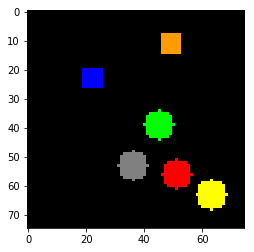

(75, 75, 3)
The shape of the nearest object to the object in red is?
circle


In [3]:
import numpy as np
idx = 20
idb = 10
img, q, a = train_dataset[idx]
visualize_img(img/255)
print img.shape
print translate_question(q[idb])
print translate_answer(a[idb])

## Visual Question and Answer Sort-of-CLEVR Architecture

This is the Visual QA Architecture proposed in the paper adapted for the Sort-of-CLEVR dataset

![](figures/Sort-of-CLEVRModel.png)

We will go through and implement each section of the architecture individually as specified by the authors in the paper.

## Convolutional Layer

As stated by the paper, Convolution Neural Network (CNN) was used to parse pixel inputs into a set of objects. The CNN takes images of size 75x75 and convolve them 4 convolutional layers each with 24 kernels, ReLU activation, and batch normalization. The output is 24 feature maps of size d x d. This CNN layer is implemented in the code below.

In [17]:
import keras
from keras.layers.convolutional import Conv2D

def ConvolutionNetworks(kernel_size=3, stride_size=2):
    def conv(model):
        model = Conv2D(24, (5, 5), strides=(stride_size, stride_size),activation='relu',input_shape=(75, 75, 3), data_format='channels_last')(model)
        model = BatchNormalization()(model)
        model = Conv2D(24, (5, 5), strides=(stride_size, stride_size),activation='relu')(model)
        model = BatchNormalization()(model)
        model = Conv2D(24, (kernel_size, kernel_size), strides=(stride_size, stride_size),activation='relu')(model)
        model = BatchNormalization()(model)
        model = Conv2D(24, (3, 3), strides=(1, 1),activation='relu')(model)
        model = BatchNormalization()(model)
        return model
    return conv

## CNN Feature Maps Post-process to Relation Network Objects

Each of the image features should constitute an object. So there are $d^2$ 24 dimensional objects in 24 feature maps of d x d dimension. According to the authors, each objects are tagged with a coordinate from a range (-1, 1) for each of the x- and y-coordinates to indicate its relative spatial position. Furthermore, the authors stated that the existence and meaning of an object-object relation should be question dependent. So they proposed that the  $g_{\theta}$ should be conditioned on the question. Modifying the Relation Networks from 

$$\text{RN}(O) = f_{\theta} (\sum_{i,j}{g_{\theta}(o_i,o_j)})$$

to

$$\text{RN}(O) = f_{\theta} (\sum_{i,j}{g_{\theta}(o_i,o_j,q)})$$

The $q$ here is simply the question encoding that we have described in the dataset.

In [5]:
import numpy as np
import keras
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, Concatenate, Add
from keras.layers.normalization import BatchNormalization


def slicer(x_loc, y_loc):
    def func(x):
        return x[:,x_loc,y_loc,:]
    return Lambda(func)

def object_tagging(o, i, d):
    coor = K.variable(value=[float(int(i/d))/d*2-1, float((i%d))/d*2-1])
    coor = K.expand_dims(coor, axis=0)
    batch_size = K.shape(o)[0]
    coor = K.tile(coor, [batch_size, 1])
    coor = Input(tensor=coor)
    o = Concatenate()([coor, o])
    return o
    
def compute_relations(objects, question):
    
    ##############################################
    # The code here is inspired by Alan Lee in https://github.com/Alan-Lee123/relation-network/blob/master/train.py
    # My original code needes too much memory to run because I required one lambda layer for each of the d^2 objects
    # however, in Alan Lee's code he was able to accombplish that with only 4.
    
    def get_top_dim_1(t):
        return t[:, 0, :, :]

    def get_all_but_top_dim_1(t):
        return t[:, 1:, :, :]

    def get_top_dim_2(t):
        return t[:, 0, :]

    def get_all_but_top_dim2(t):
        return t[:, 1:, :]
    
    slice_top_dim_1 = Lambda(get_top_dim_1)
    slice_all_but_top_dim_1 = Lambda(get_all_but_top_dim_1)
    slice_top_dim_2 = Lambda(get_top_dim_2)
    slice_all_but_top_dim2 = Lambda(get_all_but_top_dim2)
    
    d = K.int_shape(objects)[2]
    features = []
    for i in range(d):
        features1 = slice_top_dim_1(objects)
        objects = slice_all_but_top_dim_1(objects)
        for j in range(d):
            features2 = slice_top_dim_2(features1)
            features1 = slice_all_but_top_dim2(features1)
            features.append(features2)
    
    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, question]))
    
    ##############################################
#     relations = []
#     #objects are tagged CNN output that has the format of (batch_size, 24+2(tagging), d, d)
#     d = K.int_shape(objects)[2]
#     for i in xrange(d*d):
#         o_i = slicer(int(i / d), int(i % d))(objects)
# #         o_i = object_tagging(o_i, i, d)
#         for j in xrange(d*d):
#             o_j = slicer(int(j / d), int(j % d))(objects)
# #             o_j = object_tagging(o_j, j, d)
#             relations.append(Concatenate()([o_i, o_j, question]))
    return relations

## Baseline Model

In this baseline model, the Relation Network architecture is simply replaced with three layer Dense layer consisting of 256, 256 (50% drop out), and 29 units. The convolutional layer remains the same.

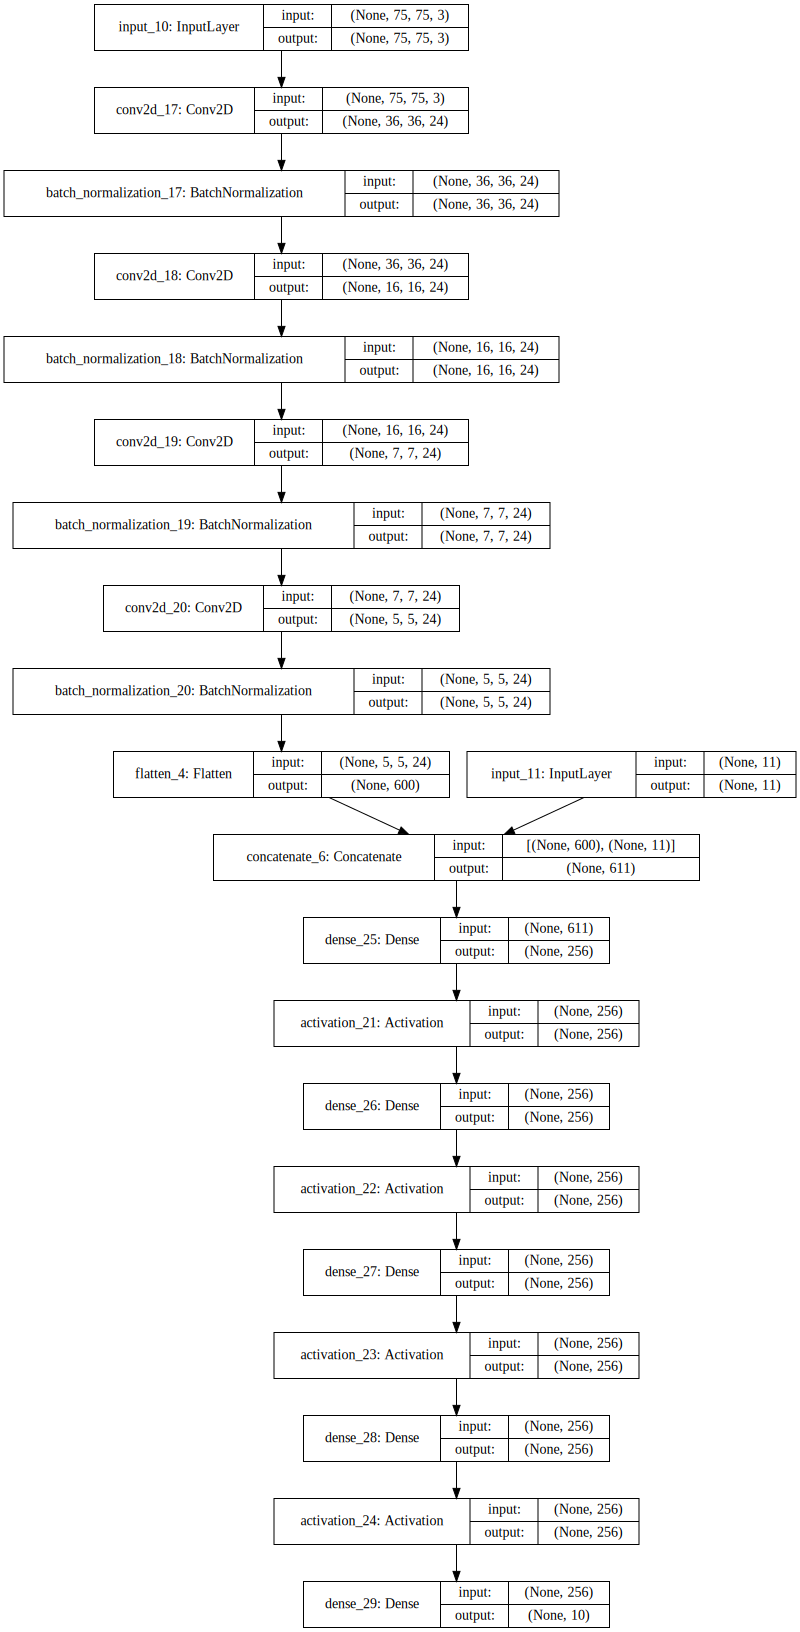

In [18]:
from keras.models import Model
from keras.layers import Input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def f_theta():
    def f(model):
        model = Dense(256)(model)
        model = Activation('relu')(model)
        model = Dense(256)(model)
        model = Activation('relu')(model)
#         model = Dropout(0.5)(model)
        model = Dense(256)(model)
        model = Activation('relu')(model)
        model = Dense(256)(model)
        model = Activation('relu')(model)
        return model
    return f

baseline_scene = Input((75, 75, 3))
baseline_question = Input((11,))
baseline_conv = ConvolutionNetworks()(baseline_scene)
baseline_conv = Flatten()(baseline_conv)
baseline_conv = Concatenate()([baseline_conv, baseline_question])
baseline_output = f_theta()(baseline_conv) 
baseline_output = Dense(10, activation='softmax')(baseline_output)
BaseLineModel = Model(inputs=[baseline_scene, baseline_question], outputs=baseline_output)
SVG(model_to_dot(BaseLineModel, show_shapes=True).create(prog='dot', format='svg'))

## Visual QA Sort-of-CLEVR Model

In the Visual QA Sort-of-CLEVR Model the Relation Layer is defined as: 

$$\text{RN}(O) = f_{\theta} (\sum_{i,j}{g_{\theta}(o_i,o_j,q)})$$

The $f_{\theta}$ and $g_{\theta}$ functions are layers of densely connected layers. As described by the authors, the $f_{\theta}$ function consists of three layer Dense layer consisting of 256, 256 (50% drop out), and 29 units. The convolutional layer remains the same, while the $g_{\theta}$ consists of four layers consisting of 256 units each layer with ReLU activation.


In [7]:
from keras.utils import plot_model

def g_th(h_unit=256, layers=4):
    def f(model):
        for n in xrange(layers):
            model = Dense(h_unit)(model)
            model = Activation('relu')(model)
        return model
    return f

def stack_layer(layers):
    def f(x):
        for k in range(len(layers)):
            x = layers[k](x)
        return x
    return f


def get_MLP(n):
    r = []
    for k in range(n):
        s = stack_layer([
            Dense(256),
            Activation('relu')
        ])
        r.append(s)
    return stack_layer(r)

def RelationNetworks(objects, question):
    g_t = get_MLP(4)
    relations = compute_relations(objects,question)
    print len(relations)
    g_all = []
    for i, r in enumerate(relations):
        g_all.append(g_t(r))
    combined_relation = Add()(g_all)
    f_out = f_theta()(combined_relation)
    return f_out

def build_tag(conv):
    d = K.int_shape(conv)[2]
    tag = np.zeros((d,d,2))
    for i in xrange(d):
        for j in xrange(d):
            tag[i,j,0] = float(int(i%d))/(d-1)*2-1
            tag[i,j,1] = float(int(j%d))/(d-1)*2-1
    tag = K.variable(tag)
    tag = K.expand_dims(tag, axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag, [batch_size,1,1,1])
    return Input(tensor=tag)

In [19]:
visual_scene = Input((75, 75, 3))
visual_question = Input((11,))
visual_conv = ConvolutionNetworks()(visual_scene)
tag = build_tag(visual_conv)
visual_conv = Concatenate()([tag, visual_conv])
visual_RN = RelationNetworks(visual_conv, visual_question)
visual_out = Dense(10, activation='softmax')(visual_RN)
VisualModel = Model(inputs=[visual_scene, visual_question, tag], outputs=visual_out)
plot_model(VisualModel, to_file='figures/VisualModel.png')

625


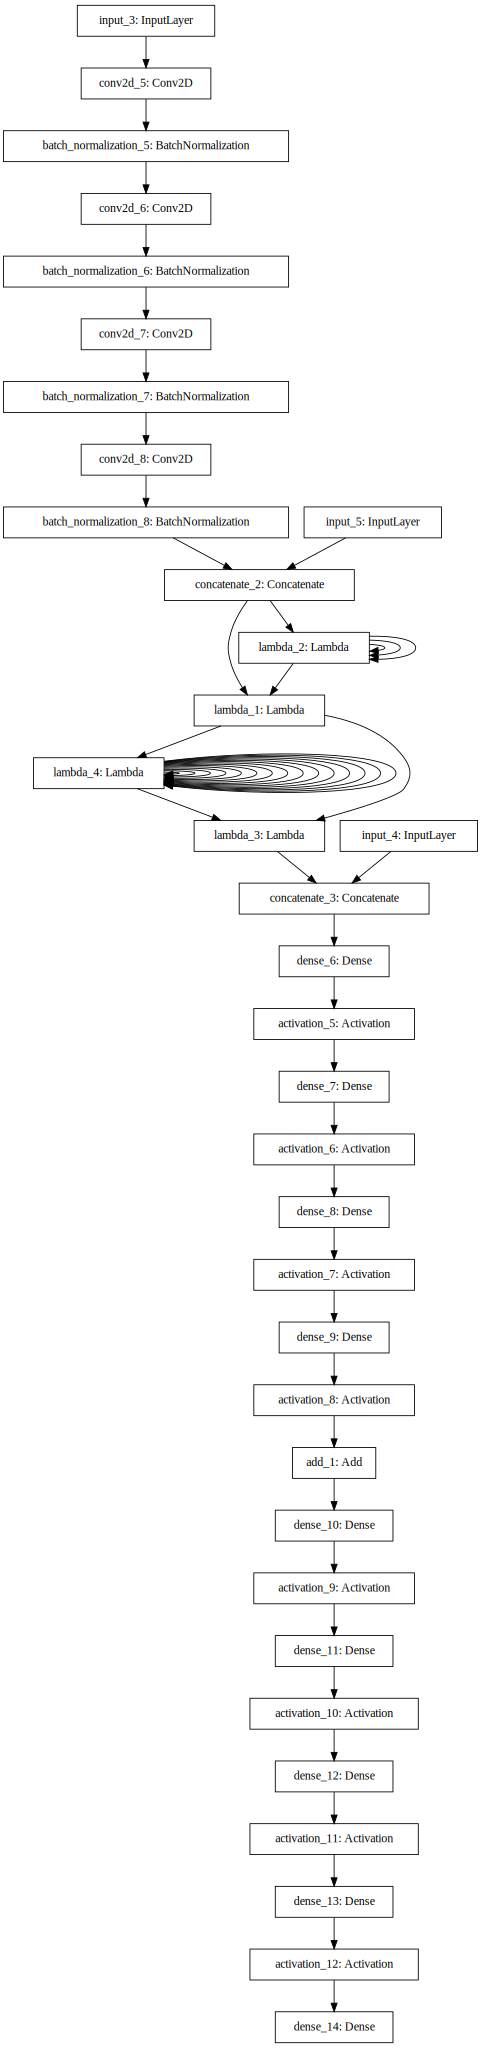

In [9]:
SVG(model_to_dot(VisualModel).create(prog='dot', format='svg'))

## Data Generator

Since the dataset is quite large ~40GB when serialized, we will need to use a Data Generator to generate the data batch that will be trained on during training. This data generator is based on [Shervine Amidi's](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html) tutorial on using data generator with Keras.

In [10]:
import numpy as np

class DataGenerator(object):
    'Generates data for Keras'
    def __init__(self, training_set, test_set, is_baseline, dim_x = 75, dim_y = 75, channel = 3, q_dim = 11, a_dim = 10, batch_size = 64, shuffle = True):
        'Initialization'
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.channel = channel
        self.q_dim = q_dim
        self.a_dim = a_dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.training_set = training_set
        self.test_set = test_set
        self.is_baseline = is_baseline

    def generate_training(self):
        'Generates batches of samples'
        # Infinite loop
        while 1:
            # Generate order of exploration of dataset
            
            if self.shuffle:
                np.random.shuffle(self.training_set)

            # Generate batches
            data_size = len(self.training_set)
            imax = int(data_size/self.batch_size)
            for i in range(imax):
                # Generate data
                imgs, questions, answers = self.__data_generation(self.training_set[i: i + self.batch_size])
                imgs, questions, answers = self.randomize(imgs, questions, answers)
                yield [imgs, questions], answers
                
    def generate_test(self):
        'Generates batches of samples'
        # Infinite loop
        while 1:
            # Generate order of exploration of dataset
            
            if self.shuffle:
                np.random.shuffle(self.test_set)

            # Generate batches
            data_size = len(self.test_set)
            imax = int(data_size/self.batch_size)
            for i in range(imax):
                # Generate data
                imgs, questions, answers = self.__data_generation(self.test_set[i: i+self.batch_size])
                imgs, questions, answers = self.randomize(imgs, questions, answers)
                yield [imgs, questions], answers
    
    def randomize(self, a, b, c):
        # Generate the permutation index array.
        permutation = np.random.permutation(a.shape[0])
        # Shuffle the arrays by giving the permutation in the square brackets.
        shuffled_a = a[permutation]
        shuffled_b = b[permutation]
        shuffled_c = c[permutation]
        return shuffled_a, shuffled_b, shuffled_c

    def __data_generation(self, dataset):
        'Generates data of batch_size samples' # X : (n_samples, v_size, v_size, v_size, n_channels)
        # Initialization
        imgs = np.empty((self.batch_size*20, self.dim_x, self.dim_y, self.channel))
        questions = np.empty((self.batch_size*20, self.q_dim), dtype = int)
        answers = np.empty((self.batch_size*20, self.a_dim), dtype = int)
        c = 0
        for img, question, answer in dataset:
            img = img/255
            for q, a in zip(question, answer):
                imgs[c, :, :, :]  = img
                questions[c, :] = q
                answers[c, :] = a
                c += 1
        return imgs, questions, answers

## Training


In [20]:
from keras.optimizers import Adam
lr = 1e-4
adam = Adam(lr=lr)
VisualModel.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
batch_size = 64
data_generator = DataGenerator(train_dataset, test_dataset, False, batch_size=batch_size)
training_generator = data_generator.generate_training()
validation_generator = data_generator.generate_test()
visualmodel_history = VisualModel.fit_generator(generator = training_generator,
                    steps_per_epoch = (len(train_dataset)*20)//batch_size,
                    validation_data = validation_generator,
                    validation_steps = (len(test_dataset)*20)//batch_size,
                    epochs = 20)

Epoch 1/20
3062/3062 [==============================] - 4652s 2s/step - loss: 3.4076 - acc: 0.7004 - val_loss: 2.3034 - val_acc: 0.4852
Epoch 2/20
3062/3062 [==============================] - 4648s 2s/step - loss: 1.1961 - acc: 0.8265 - val_loss: 2.2126 - val_acc: 0.5052
Epoch 3/20
3062/3062 [==============================] - 4649s 2s/step - loss: 1.1460 - acc: 0.8326 - val_loss: 2.1040 - val_acc: 0.4916
Epoch 4/20
3062/3062 [==============================] - 4650s 2s/step - loss: 1.2032 - acc: 0.8315 - val_loss: 2.1042 - val_acc: 0.5142
Epoch 5/20
3062/3062 [==============================] - 4650s 2s/step - loss: 1.1961 - acc: 0.8347 - val_loss: 1.9800 - val_acc: 0.5333
Epoch 6/20
3062/3062 [==============================] - 4653s 2s/step - loss: 1.1720 - acc: 0.8410 - val_loss: 2.0743 - val_acc: 0.5217
Epoch 7/20
3062/3062 [==============================] - 4649s 2s/step - loss: 0.5789 - acc: 0.8667 - val_loss: 1.3344 - val_acc: 0.5481
Epoch 8/20
3062/3062 [==========================

In [ ]:
VisualModel.save('VisualModelLarge.h5')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(baseline_history.history['acc'])
plt.plot(baseline_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('figures/VisualModelAccuracy')
plt.show()

In [10]:
from keras.optimizers import Adam
lr = 1e-4
adam = Adam(lr=lr)
BaseLineModel.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [11]:
data_generator = DataGenerator(train_dataset, test_dataset, False)
training_generator = data_generator.generate_training()
validation_generator = data_generator.generate_test()
baseline_history = BaseLineModel.fit_generator(generator = training_generator,
                    steps_per_epoch = (len(train_dataset)*20)//64,
                    validation_data = validation_generator,
                    validation_steps = (len(test_dataset)*20)//64,
                    epochs = 50)
BaseLineModel.save('BaseLineModel.h5')

Epoch 1/50
3062/3062 [==============================] - 878s 287ms/step - loss: 0.6143 - acc: 0.7146 - val_loss: 1.2229 - val_acc: 0.4849
Epoch 2/50
3062/3062 [==============================] - 875s 286ms/step - loss: 0.5219 - acc: 0.7579 - val_loss: 1.2298 - val_acc: 0.5125
Epoch 3/50
3062/3062 [==============================] - 881s 288ms/step - loss: 0.4556 - acc: 0.8146 - val_loss: 1.3844 - val_acc: 0.4877
Epoch 4/50
3062/3062 [==============================] - 884s 289ms/step - loss: 0.4170 - acc: 0.8428 - val_loss: 1.3522 - val_acc: 0.5048
Epoch 5/50
3062/3062 [==============================] - 878s 287ms/step - loss: 0.3968 - acc: 0.8551 - val_loss: 1.3241 - val_acc: 0.5032
Epoch 6/50
3062/3062 [==============================] - 874s 286ms/step - loss: 0.3698 - acc: 0.8695 - val_loss: 1.3784 - val_acc: 0.5177
Epoch 7/50
3062/3062 [==============================] - 871s 285ms/step - loss: 0.3542 - acc: 0.8759 - val_loss: 1.2341 - val_acc: 0.5616
Epoch 8/50
3062/3062 [============

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3062/3062 [==============================] - 887s 290ms/step - loss: 0.0272 - acc: 0.9931 - val_loss: 1.0727 - val_acc: 0.8078
Epoch 39/50
2637/3062 [========================>.....] - ETA: 2:00 - loss: 0.0226 - acc: 0.9942

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3062/3062 [==============================] - 878s 287ms/step - loss: 0.0228 - acc: 0.9943 - val_loss: 0.9033 - val_acc: 0.8298
Epoch 41/50
2828/3062 [==========================>...] - ETA: 1:06 - loss: 0.0234 - acc: 0.9943

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3062/3062 [==============================] - 878s 287ms/step - loss: 0.0191 - acc: 0.9952 - val_loss: 0.9202 - val_acc: 0.8304
Epoch 44/50
  48/3062 [..............................] - ETA: 14:17 - loss: 0.0161 - acc: 0.9959

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3062/3062 [==============================] - 879s 287ms/step - loss: 0.0156 - acc: 0.9961 - val_loss: 0.9897 - val_acc: 0.8293
Epoch 46/50
 312/3062 [==>...........................] - ETA: 13:09 - loss: 0.0155 - acc: 0.9962

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3062/3062 [==============================] - 884s 289ms/step - loss: 0.0143 - acc: 0.9964 - val_loss: 1.0820 - val_acc: 0.8147
Epoch 47/50
3062/3062 [==============================] - 881s 288ms/step - loss: 0.0138 - acc: 0.9966 - val_loss: 0.9665 - val_acc: 0.8387
Epoch 48/50
3062/3062 [==============================] - 886s 289ms/step - loss: 0.0143 - acc: 0.9967 - val_loss: 1.0113 - val_acc: 0.8259
Epoch 49/50
3062/3062 [==============================] - 886s 289ms/step - loss: 0.0128 - acc: 0.9970 - val_loss: 0.9077 - val_acc: 0.8455
Epoch 50/50
3062/3062 [==============================] - 885s 289ms/step - loss: 0.0105 - acc: 0.9974 - val_loss: 0.9702 - val_acc: 0.8470


In [232]:
BaseLineModel.save('BaseLineModel.h5')

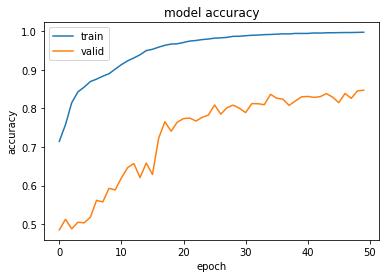

In [14]:
import matplotlib.pyplot as plt

plt.plot(baseline_history.history['acc'])
plt.plot(baseline_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('figures/BaselineAccuracy')
plt.show()

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11639590226170761338
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 357105664
locality {
  bus_id: 1
}
incarnation: 1621610635963919990
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [15]:

import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Embedding, \
    LSTM, Bidirectional, Lambda, Concatenate, Add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization, regularizers
from keras.optimizers import Adam, RMSprop
import gc
import subprocess
import pickle

mxlen = 32
embedding_dim = 50
lstm_unit = 64
MLP_unit = 128
epochs = 200
batch_size = 256
l2_norm = 1e-4



def bn_layer(x, conv_unit):
    def f(inputs):
        md = Conv2D(x, (conv_unit, conv_unit), padding='same', kernel_initializer='he_normal')(inputs)
        md = BatchNormalization()(md)
        return Activation('relu')(md)

    return f


def conv_net(inputs):
    model = bn_layer(16, 3)(inputs)
    model = MaxPooling2D((4, 4), 4)(model)
    model = bn_layer(16, 3)(model)
    model = MaxPooling2D((3, 3), 3)(model)
    model = bn_layer(16, 3)(model)
    model = MaxPooling2D((2, 2), 2)(model)
    model = bn_layer(32, 3)(model)
    return model


input1 = Input((50, 200, 3))
input2 = Input((mxlen,))
cnn_features = conv_net(input1)
# embedding_layer = prepare.embedding_layer(prepare.tokenizer.word_index, prepare.get_embeddings_index(), mxlen)
# embedding = embedding_layer(input2)
embedding = Embedding(mxlen, embedding_dim)(input2)
bi_lstm = Bidirectional(LSTM(lstm_unit, implementation=2, return_sequences=False,
                             recurrent_regularizer=regularizers.l2(l2_norm), recurrent_dropout=0.25))
lstm_encode = bi_lstm(embedding)
shapes = cnn_features.shape
w, h = shapes[1], shapes[2]


def slice_1(t):
    return t[:, 0, :, :]


def slice_2(t):
    return t[:, 1:, :, :]


def slice_3(t):
    return t[:, 0, :]


def slice_4(t):
    return t[:, 1:, :]


slice_layer1 = Lambda(slice_1)
slice_layer2 = Lambda(slice_2)
slice_layer3 = Lambda(slice_3)
slice_layer4 = Lambda(slice_4)

features = []
for k1 in range(w):
    features1 = slice_layer1(cnn_features)
    cnn_features = slice_layer2(cnn_features)
    for k2 in range(h):
        features2 = slice_layer3(features1)
        features1 = slice_layer4(features1)
        features.append(features2)

relations = []
concat = Concatenate()
for feature1 in features:
    for feature2 in features:
        relations.append(concat([feature1, feature2, lstm_encode]))

print len(features)
def stack_layer(layers):
    def f(x):
        for k in range(len(layers)):
            x = layers[k](x)
        return x
    return f


def get_MLP(n):
    r = []
    for k in range(n):
        s = stack_layer([
            Dense(MLP_unit),
            BatchNormalization(),
            Activation('relu')
        ])
        r.append(s)
    return stack_layer(r)


def bn_dense(x):
    y = Dense(MLP_unit)(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(0.5)(y)
    return y


g_MLP = get_MLP(3)

mid_relations = []
for r in relations:
    mid_relations.append(g_MLP(r))
combined_relation = Add()(mid_relations)

rn = bn_dense(combined_relation)
rn = bn_dense(rn)
pred = Dense(1, activation='sigmoid')(rn)

model = Model(inputs=[input1, input2], outputs=pred)
optimizer = Adam(lr=3e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


256


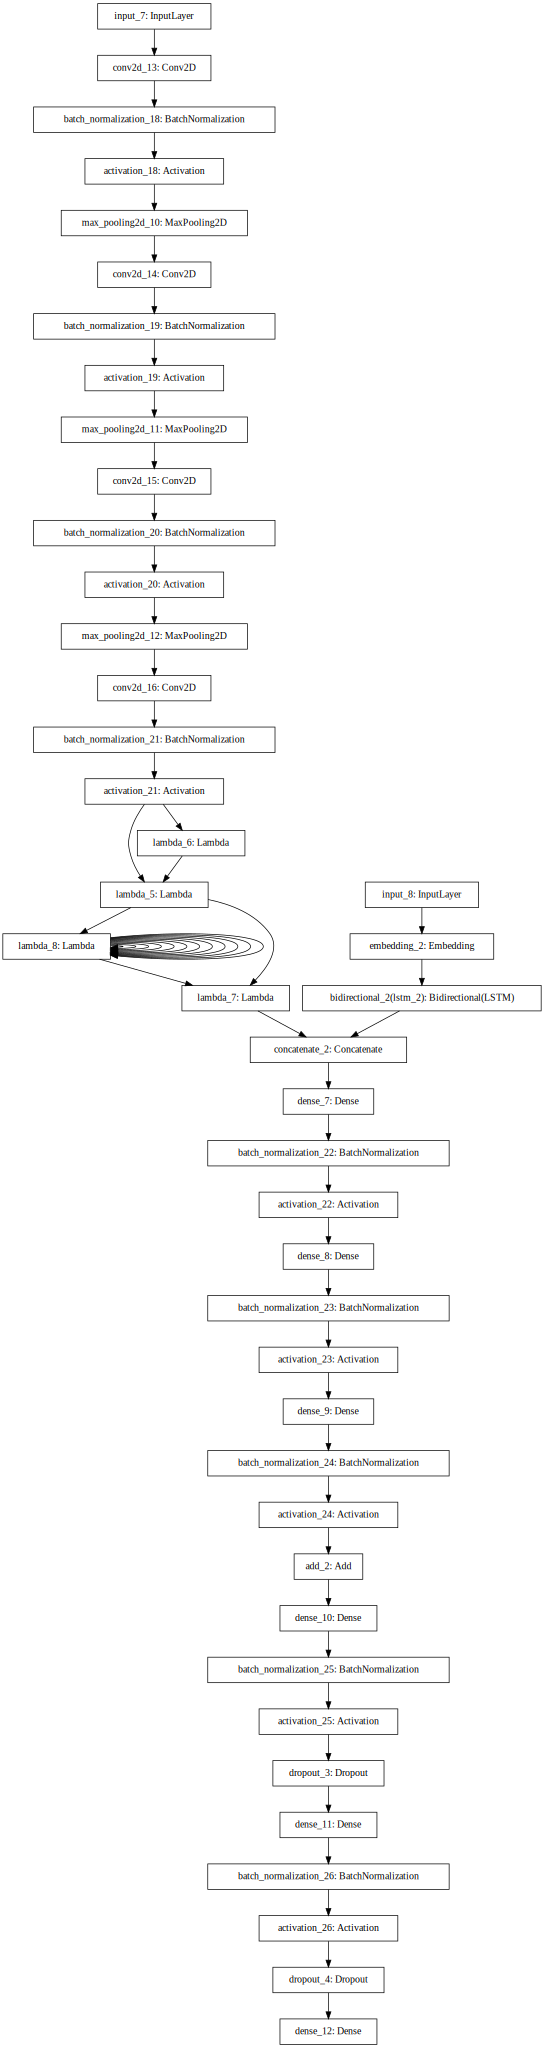

In [15]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))